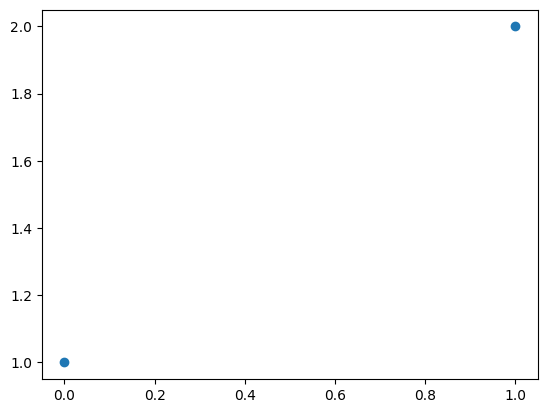

In [1]:
import sys
sys.path.append('f:/seismic/code/core')
sys.path.append('/seismic/code/core')
sys.path.append('/kaggle/input/my-seis-library/')
import kaggle_support as kgs
import importlib
import numpy as np
import matplotlib.pyplot as plt
import glob
import copy
import os
import seis_forward
import seis_test
import seis_invert
import seis_prior
import cupy as cp
plt.scatter([0,1],[1,2])
#fls.download_kaggle_dataset('jeroencottaar/byu-many-models-2/', fls.result_dir + '/many_full_res/')

10000
FlatVel_A


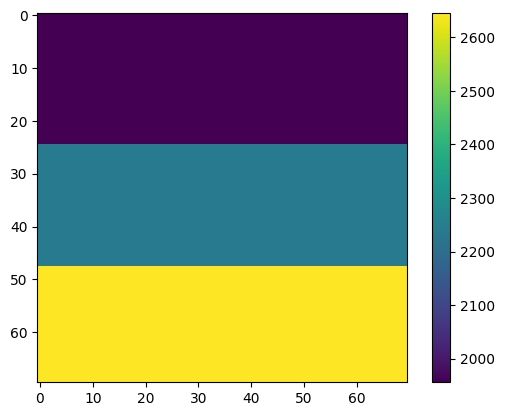

In [2]:
importlib.reload(kgs)
data=kgs.load_all_train_data()
print(len(data))
for d in data:
    d.check_constraints()
d = data[6001]
print(d.family)
d.load_to_memory()
plt.figure()
plt.imshow(cp.asnumpy(d.velocity.data));plt.colorbar();#plt.clim([-3,3])

In [3]:
# TODO: don't use seis_correct, bigger variations, velB
seis_correct = seis_forward.vel_to_seis(d.velocity, d.seismogram)[0]
offset_vector = cp.array(1e1*np.random.default_rng(seed=0).normal(0,1,size=d.velocity.to_vector().shape), dtype=kgs.base_type_gpu)
velocity_offset = copy.deepcopy(d.velocity)
velocity_offset.from_vector(velocity_offset.to_vector() + offset_vector)
prior = seis_prior.RowTotalVariation(λ=1e-20)
basis_functions = prior.basis_functions()
print(seis_invert.cost_and_gradient(cp.linalg.solve(basis_functions.T@basis_functions, basis_functions.T@(d.velocity.to_vector())), seis_correct.to_vector(), prior, basis_functions))
print(seis_invert.cost_and_gradient(cp.linalg.solve(basis_functions.T@basis_functions, basis_functions.T@(velocity_offset.to_vector())), seis_correct.to_vector(), prior, basis_functions))
print('base RMS', kgs.rms(cp.asnumpy(cp.mean(velocity_offset.data - d.velocity.data,axis=0)[:,None] + 0*d.velocity.data)))
print('base seis diff', kgs.rms(cp.asnumpy(seis_correct.to_vector() - seis_forward.vel_to_seis(velocity_offset, seis_correct)[0].to_vector())))

1.0971057949745318e-19
3.188366779165863e-06
base RMS 1.0856655951544898
base seis diff 0.010011741893431713


In [4]:
importlib.reload(seis_invert)
λ_vals = 10**np.linspace(-13,-7,3)
λ_vals = [10**-7]
maxiter=100
res = [[],[]]
rms_vals = [[],[]]
cost_vals = [[],[]]
res_vals = [[],[]]

In [ ]:
for λ in λ_vals:    
    prior = seis_prior.RowTotalVariation(λ=λ)
    seis_invert.true_vel = d.velocity
    res[0].append(seis_invert.seis_to_vel(seis_correct, d.velocity, prior, maxiter=maxiter))
    print('done1', λ)
    res[1].append(seis_invert.seis_to_vel(seis_correct, velocity_offset, prior,maxiter=maxiter))
    print('done2', λ)
    for ii in range(2):
        rms_vals[ii].append(cp.asnumpy(kgs.rms(res[ii][-1].to_vector()-d.velocity.to_vector())))
        cost_vals[ii].append( cp.asnumpy(
            seis_invert.cost_and_gradient(cp.linalg.solve(basis_functions.T@basis_functions, basis_functions.T@(res[ii][-1].to_vector())), seis_correct.to_vector(), prior, basis_functions) ))
        res_vals[ii].append(cp.asnumpy(kgs.rms( kgs.rms( seis_correct.data - seis_forward.vel_to_seis(res[ii][-1], d.seismogram)[0].data ) )))
    print('RMS', λ, rms_vals[0], rms_vals[1])
    print('Cost', λ, cost_vals[0], cost_vals[1])
    print('res', λ, res_vals[0], res_vals[1])

1.0971057949745318e-06 0.0
1.101703022301137e-06 0.12070577325549754
1.0968227735832639e-06 0.023300802230899646
1.0964940326103016e-06 0.04757763372316436
1.0987708920629579e-06 0.0763684219920992
1.09645656311752e-06 0.050808755458265104


In [ ]:
%debug

In [ ]:
for to_plot in [[rms_vals, 'Velocity RMS error'], [res_vals, 'Seismogram RMS error'], [cost_vals, 'Cost']]:
    plt.figure()
    plt.loglog(λ_vals[:2], to_plot[0][0])
    plt.loglog(λ_vals[:2], to_plot[0][1])
    plt.xlabel('λ')
    plt.ylabel(to_plot[1])
    plt.grid(True)
    plt.legend(('Starting from correct', 'Starting from offset'))

In [ ]:
plt.figure()
plt.imshow( cp.asnumpy(velocity_offset.data - d.velocity.data));plt.colorbar()
plt.figure()
plt.imshow( cp.asnumpy(cp.mean(velocity_offset.data - d.velocity.data,axis=0)[:,None] + 0*d.velocity.data));plt.colorbar()
plt.title(kgs.rms (cp.mean(velocity_offset.data - d.velocity.data,axis=0)[:,None] + 0*d.velocity.data))
for i,λ in enumerate(λ_vals): 
    _,ax=plt.subplots(1,2,figsize=(12,6))
    for ii in range(2):
        plt.sca(ax[ii])
        plt.imshow( cp.asnumpy(res[ii][i].data - d.velocity.data));plt.colorbar()
        plt.title(rms_vals[ii][i])
    plt.suptitle(λ)

In [ ]:
rms_vals

In [ ]:
cost_vals

In [ ]:
res_vals

In [ ]:
λ_vals = [-13]